# Applied Data Analysis — Homework 4

Import common libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data and display a sample. The latter is just for ensuring that the data could be read; all columns are not shown as they are already explained in the recommended reading, as well as in the provided `DATA.md` file.

In [2]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv', parse_dates=['birthday'])
df.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
57034,mickael-tacalfred,Mickaël Tacalfred,Stade Reims,France,1981-04-23,175.0,69.0,NaN,1,1,...,NaN,1138,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
138041,dennis-diekmeier,Dennis Diekmeier,Hamburger SV,Germany,1989-10-20,188.0,79.0,Right Fullback,8,0,...,0.25,2940,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
55398,hal-robson-kanu,Hal Robson-Kanu,Reading FC,England,1989-05-21,170.0,74.0,NaN,2,2,...,NaN,1098,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
138254,petr-jiracek,Petr Jiráček,Hamburger SV,Germany,1986-02-03,180.0,77.0,Left Midfielder,6,1,...,0.00,2940,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
123513,abel-aguilar,Abel Aguilar,Deportivo La Coruña,Spain,1985-06-01,185.0,78.0,Defensive Midfielder,1,1,...,0.25,2633,31,BRA,0.368946,2411.0,0.000173,0.637172,2475.0,0.000913


Just out of curiosity, which is the player with the most interactions with a referee?

In [3]:
df.sort_values('games', ascending=False)[:5]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
48893,philipp-lahm,Philipp Lahm,Bayern München,Germany,1983-11-11,170.0,66.0,Left Fullback,47,29,...,0.25,933,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
48390,bastian-schweinsteiger,Bastian Schweinsteiger,Bayern München,Germany,1984-01-08,183.0,79.0,Defensive Midfielder,46,28,...,0.25,933,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
54811,paul-scholes,Paul Scholes,Manchester United,England,1974-11-16,170.0,72.0,Center Midfielder,44,28,...,0.00,1095,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
97628,frank-lampard,Frank Lampard,Chelsea FC,England,1978-06-20,183.0,77.0,Center Midfielder,44,29,...,0.25,2080,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
59844,michael-carrick,Michael Carrick,Manchester United,England,1981-07-28,186.0,74.0,Center Midfielder,42,24,...,0.00,1214,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037


## Cleaning the data

As is described in the recommended reading, all games for each player are included.
This is evident in the 47 games Philipp Lahm played under a single referee — a feat that could not be archieved in the Bundesliga, which has less games per team per season.

This results in a lot of noise.
As done in the recommended reading, we therefore remove all dyads (player-referee pairs) for referees that do not have connections to at least 22 players, the minimum for a single game.

In [4]:
df_ref_group_sizes = df.groupby('refNum').size()
# Referees that have at least 22 associated players
good_df_refs = df_ref_group_sizes[df_ref_group_sizes >= 22]

df = df[df['refNum'].isin(good_df_refs.index.values)]

Just to be sure, verify that the new minimum is actually 22:

In [5]:
df.groupby('refNum').size().min()

22

The classifier only supports dealing with numbers, so we convert the birthdate to an int:

In [6]:
df['birthday'] = df['birthday'].astype('int64')

df['birthday'].sample(5)

11506     629078400000000000
10299     614736000000000000
70412     272160000000000000
39398     621129600000000000
145603    644544000000000000
Name: birthday, dtype: int64

Let's check whether one of the two raters has a tendency to rate lower than the other:

In [7]:
rating_differences = (df['rater2'] - df['rater1']).abs()

rating_differences.mean()

0.05836231578577576

With a fifth of a step, this does not seem substantial.
Let's check how often they actually disagree substantially (using half of the available scale):

In [8]:
rating_differences[rating_differences >= .5].count()

163

Given the small count, we should be fine with ignoring them.

Next, we create a new column that merges the two skin tone ratings.

In [9]:
df['skinRating'] = (df['rater1'] + df['rater2']) / 2

df.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinRating
91868,philipp-lahm,Philipp Lahm,Bayern München,Germany,437356800000000000,170.0,66.0,Left Fullback,8,6,...,1970,32,CHE,0.345305,1886.0,0.000219,0.377193,1938.0,0.000823,0.250
101335,federico-macheda,Federico Macheda,Manchester United,England,682819200000000000,185.0,72.0,Center Forward,1,0,...,2176,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.000
55762,juan-albin,Juan Albín,Espanyol Barcelona,Spain,521942400000000000,179.0,77.0,Left Midfielder,1,1,...,1105,22,POL,0.369958,1021.0,0.000412,0.831268,1049.0,0.002034,0.375
128760,kevin-grosskreutz,Kevin Großkreutz,Borussia Dortmund,Germany,585273600000000000,186.0,72.0,Left Winger,1,1,...,2769,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.000
53396,christian-stuani,Christian Stuani,Espanyol Barcelona,Spain,534556800000000000,186.0,77.0,Center Forward,1,1,...,1064,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.250


At this point, we do not remove further values.
The intuition is that even missing values might have a relation to the skin color.

## Task 1

> Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

#### From dyads to player stats

First, we need to get per-player stats from the dyads.
We do this by aggregating all statistics.

To know what we're dealing with, we print a list of all data types:

In [10]:
df.dtypes

playerShort       object
player            object
club              object
leagueCountry     object
birthday           int64
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
skinRating       float64
dtype: object

Based on this, we aggregate stats for all players:

In [11]:
def most_common(val):
    val_counts = val.value_counts()
    if val_counts.size > 0:
        return val_counts.keys()[0]

player_df = df.groupby('playerShort').agg({
    'club': most_common,
    'leagueCountry': most_common,
    'position': most_common,
        
    'birthday': 'max', # Use the highest age

    'height': 'mean',
    'weight': 'mean',
    'meanIAT': 'mean',
    'nIAT': 'mean',
    'seIAT': 'mean',
    'meanExp': 'mean',
    'nExp': 'mean',
    'seExp': 'mean',
    'skinRating': 'mean',
        
    'games': 'sum',
    'victories': 'sum',
    'ties': 'sum',
    'defeats': 'sum',
    'goals': 'sum',
    'yellowCards': 'sum',
    'yellowReds': 'sum',
    'redCards': 'sum',
})

player_df.reset_index() # get the df back from groupby

player_df.sample(5)

,seIAT,leagueCountry,birthday,ties,club,defeats,meanExp,position,redCards,nIAT,...,height,yellowReds,meanIAT,goals,nExp,yellowCards,victories,games,skinRating,seExp
playerShort,,,,,,,,,,,,,,,,,,,,,
andre-santos,0.000677,England,428716800000000000,24,Arsenal FC,27,0.488431,Left Fullback,0,11978.314286,...,180.0,0,0.352375,17,12536.228571,27,79,130,0.500,0.003718
jannik-loehden,0.000055,Germany,616550400000000000,16,Hannover 96,17,0.335967,Center Back,0,7749.000000,...,201.0,0,0.336628,5,7974.000000,12,23,56,0.000,0.000225
christian-fuchs,0.000455,Germany,520819200000000000,78,FC Schalke 04,129,0.483149,Left Fullback,0,5847.242991,...,186.0,2,0.353948,22,6079.130841,55,148,355,0.000,0.002213
fabio-coentrao,0.000404,Spain,594518400000000000,38,Real Madrid,55,0.601172,Left Fullback,1,26500.978495,...,179.0,5,0.366833,15,27323.967742,50,144,237,0.375,0.001902
julian-riedel,0.000074,Germany,686880000000000000,26,Bayer Leverkusen,36,0.342149,Left Fullback,0,7642.371429,...,183.0,0,0.337040,4,7864.285714,8,49,111,0.250,0.000322


`sklearn` chokes on undefined values.
Therefore, we first remove all players without a `skinRating`, as they cannot be classified.

In [12]:
total_player_number = player_df['skinRating'].size
ratingless_player_count = total_player_number - player_df['skinRating'].count()
print('Dropping ' + str(ratingless_player_count) + '/' + str(total_player_number) + ' players')

player_df.dropna(subset=['skinRating'], inplace=True)

player_df['skinRating'].size # display remaining to ensure it succeeded

Dropping 466/2050 players


1584

For the other values, let's fill them in with something unique, so these values can be classified properly.
We once again do not remove them as a missing value might represent a bias in the data gathering.

First, we display property counts.
Properties with lower counts have missing values.
As we have already filtered out players without a `skinRating`, we use that number as a baseline.

In [13]:
player_df.count() - player_df['skinRating'].count()

seIAT              0
leagueCountry      0
birthday           0
ties               0
club               0
defeats            0
meanExp            0
position        -152
redCards           0
nIAT               0
weight           -21
height            -3
yellowReds         0
meanIAT            0
goals              0
nExp               0
yellowCards        0
victories          0
games              0
skinRating         0
seExp              0
dtype: int64

Only `position`, `weight` and `height` have missing entries.
As before, perhaps missing values have a significance, so let's fill them in with something unique.

In [14]:
player_df['position'].fillna('missing', inplace=True)
player_df['position'].count()

1584

In [15]:
# Neither weight nor height can be 0 under ordinary circumstances

player_df.fillna(0, inplace=True)
player_df.count() - player_df['skinRating'].count()

seIAT            0
leagueCountry    0
birthday         0
ties             0
club             0
defeats          0
meanExp          0
position         0
redCards         0
nIAT             0
weight           0
height           0
yellowReds       0
meanIAT          0
goals            0
nExp             0
yellowCards      0
victories        0
games            0
skinRating       0
seExp            0
dtype: int64

All cleaned up, so let's get to the interesting part:

__Note:__ The following is largely based on the [ensemble](http://scikit-learn.org/stable/modules/ensemble.html#forest) and [cross-validation guides](http://scikit-learn.org/stable/modules/cross_validation.html) from `scikit-learn`.

#### Preparing & split the test set

First, we have to convert string values to numbers to make them accessible to the classifier.
We are using dummies for that:

In [16]:
player_df_dummies = pd.get_dummies(player_df)

Next, we split the players to two sets, one for training, one for testing.
We use 2/5 of the dataset for testing.

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Needed for cross-validation

X = player_df_dummies.copy()
X.drop('skinRating', inplace=True, axis=1)

Y = LabelEncoder().fit_transform(player_df['skinRating'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=0)

All set, so let's use the classifier (with default parameters):

In [18]:
from sklearn.ensemble import RandomForestClassifier

def get_classifier(X_train, y_train, n_estimators=None, max_depth=None):
    classifier = RandomForestClassifier()
    return classifier.fit(X_train, y_train)

first_classifier = get_classifier(X_train, y_train)

#### How well does the model perform?



In [19]:
from sklearn.model_selection import cross_val_score

def get_cross_val_scores(classifier, X_test, y_test, cv=20):
    f1_score = np.mean(cross_val_score(classifier, X_test, y_test, scoring='f1_macro', cv=cv))
    accuracy = np.mean(cross_val_score(classifier, X_test, y_test, scoring='accuracy', cv=cv))
    
    return (f1_score, accuracy)

f1_score, accuracy = get_cross_val_scores(first_classifier, X_test, y_test, cv=3)

'Accuracy score is ' + str(accuracy) + ', the F1-score is ' + str(f1_score)

/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Accuracy score is 0.269860419899, the F1-score is 0.129528672493'

Interesting enough, some outcomes seem to be impossible to predict (see the warning).
Also, both our accuracy and our F1-score are abysmal, we should improve upon that.

Consequently, we simplify the problem:
From now on, we only distinguish between light and dark skin.

In [20]:
skin_ratings = player_df['skinRating'].map(lambda x: x > .5)
skin_ratings.sample(5)

playerShort
gervinho           True
davide-santon     False
simon-davies      False
onyekachi-apam     True
arribas_2         False
Name: skinRating, dtype: bool

What is actually the distribution of our values?
With `True` signifying dark-skinned players:

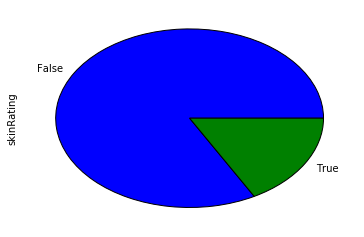

In [21]:
skin_ratings.value_counts().plot.pie()

As a percentage (using implicit casts from booleans to integers):

In [22]:
1 - skin_ratings.sum() / skin_ratings.size

0.83017676767676774

So whatever result we archieve has to better than this, otherwise always returning `False` (for light-skinned) would outperform our result.

In [23]:
Y = LabelEncoder().fit_transform(skin_ratings)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=0)

classifier = get_classifier(X_train, y_train)

f1_score, accuracy = get_cross_val_scores(classifier, X_test, y_test)

'Accuracy score is ' + str(accuracy) + ', the F1-score is ' + str(f1_score)

'Accuracy score is 0.839238147605, the F1-score is 0.537213540033'

That looks much better, although we only outperform a constant return value by a small margin.
Also, the F1-score is pretty low.

In [24]:
def get_classifier_score(n_estimators, max_depth):
    classifier = get_classifier(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth)
    f1_score, accuracy = get_cross_val_scores(classifier, X_test, y_test)
    
    return (n_estimators, max_depth, f1_score, accuracy)

classifier_data = [
    get_classifier_score(n_estimators, max_depth)
    for n_estimators in range(1, 30, 2) for max_depth in range(1, 30, 2)
]

len(classifier_data)

225

In [25]:
tree_options_df = pd.DataFrame.from_records(
    data=classifier_data,
    columns=['n_estimators', 'max_depth', 'f1_score', 'accuracy']
)
tree_options_df.sample(5)

,n_estimators,max_depth,f1_score,accuracy
26,3,23,0.563163,0.842313
43,5,27,0.562889,0.834248
35,5,11,0.573875,0.837915
25,3,21,0.552263,0.840795
108,15,7,0.579566,0.834595


What are the maximum values for F1-score?

In [26]:
tree_options_df.sort_values('f1_score', ascending=False).head()

,n_estimators,max_depth,f1_score,accuracy
214,29,9,0.627489,0.840848
111,15,13,0.623151,0.836154
157,21,15,0.614649,0.837676
126,17,13,0.614065,0.837720
123,17,7,0.614059,0.831372


How about the accuracy?

In [27]:
tree_options_df.sort_values('accuracy', ascending=False).head()

,n_estimators,max_depth,f1_score,accuracy
4,1,9,0.575160,0.855166
68,9,17,0.557799,0.853650
213,29,7,0.579565,0.853405
127,17,15,0.586183,0.851744
93,13,7,0.605928,0.848812


There does not seem to be a clear tendency, which can be further seen when visualizing the result (both times using 25 as `max_depth` and `n_estimators`, but other values show similar result):

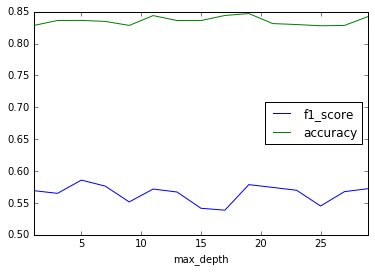

In [28]:
without_n_estimators_df = tree_options_df[tree_options_df['n_estimators'] == 25].drop('n_estimators', axis=1)

without_n_estimators_df.set_index('max_depth').plot.line()

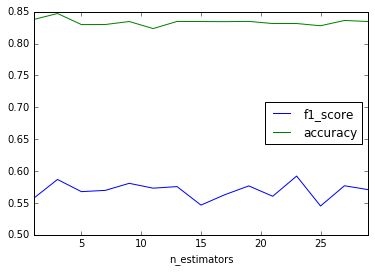

In [29]:
without_max_depth_df = tree_options_df[tree_options_df['max_depth'] == 25].drop('max_depth', axis=1)

without_max_depth_df.set_index('n_estimators').plot.line()

#### Feature importance

Next, we want to look at which features have the greatest impact for our classifier (once again using the classifier with default values).

> Once you assessed your model, inspect the `feature_importances_` attribute and discuss the obtained results.

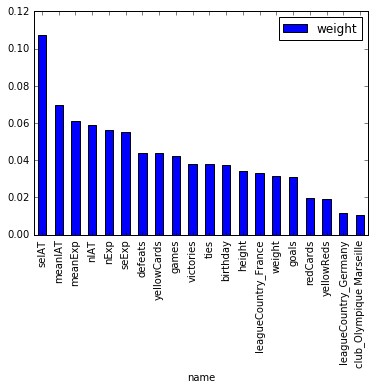

In [30]:
def get_important_features(X, classifier):
    feature_pairs = [(X.columns[i], classifier.feature_importances_[i]) for i in range(0, len(X.columns))]

    feature_df = pd.DataFrame(data=feature_pairs, columns=['name', 'weight'])
    feature_df.sort_values('weight', ascending=False, inplace=True)

    return feature_df[feature_df['weight'] >= feature_df['weight'].mean()]
    
def plot_feature_importance(X, classifier):
    get_important_features(X, classifier).set_index('name').plot.bar()

plot_feature_importance(X, classifier)

As could be expected, the values associated with biases have the greatest importance.
Interesting enough, playing in France is ranked pretty heigh, especially when playing for Olympique Marseille.

The number of red and yellow cards, while important, only plays a minor role to our classifier.

> With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

Let's look into our initial classifier. With the broader range of possible skin colors, are there other features that are judged to be important?

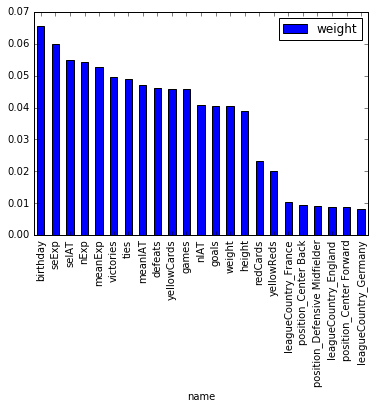

In [31]:
plot_feature_importance(X, first_classifier)

As this classifier tries to differenciate between a wide range of skin colors, its results should be different from what we've seen before. Nevertheless, the important features remained the same, with some changes in their order.

### Task 1 — Bonus

> Plot the learning curves against at least 2 different sets of parameters passed to your Random Forest.
To obtain smooth curves, partition your data in at least 20 folds.
Can you find a set of parameters that leads to high bias, and one which does not?

This was already done as part of the regular analysis.

## Task 2

> Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters.
Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters?
Discuss the obtained results.

We use `KMeans` to cluster our data, based on the [`scikit-learn` guide](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) about it.
The `X` variable obtained above is reused, as it contains all the required features (not including the skin color — which would simplify this task quite a lot).

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score

def get_silhouette_score(X):
    classifier = KMeans(n_clusters=2, random_state=0)
    labels = classifier.fit_predict(X)
    
    silhouette = silhouette_score(X, labels)
    # calculate accuracy for both clusters -- both of them could represent our classification
    accuracy = max(accuracy_score(Y, labels), accuracy_score(1 - Y, labels))
    
    return silhouette, accuracy

get_silhouette_score(X)

(0.58120609211175134, 0.50883838383838387)

Now we are able to get the silhouette and accuracy scores for our data.
Next, we explore which combination of categories actually leads to high scores.

To reduce computation time, we only consider the ten features our previous classifier found to be of greatest importance.

In [33]:
important_feature_names = get_important_features(X, classifier)['name'][:10]
important_feature_names

0           seIAT
10        meanIAT
4         meanExp
6            nIAT
12           nExp
16          seExp
3         defeats
13    yellowCards
15          games
14      victories
Name: name, dtype: object

In [34]:
from itertools import combinations

scores = []

for i in range(1, len(important_feature_names) + 1):
    # This takes a while, so print status messages
    print('Computing combinations of length ' + str(i))
    
    for combination in combinations(important_feature_names, i):
        feature_df = pd.DataFrame(X, columns=combination)
        scores.append((', '.join(combination), *get_silhouette_score(feature_df)))

scores[50:5]

Computing combinations of length 1
Computing combinations of length 2
Computing combinations of length 3
Computing combinations of length 4
Computing combinations of length 5
Computing combinations of length 6
Computing combinations of length 7
Computing combinations of length 8
Computing combinations of length 9
Computing combinations of length 10


[]

In [35]:
score_df = pd.DataFrame(scores, columns=['Features', 'Silhouette score', 'Accuracy'])
score_df.set_index('Features')
top_values = score_df.sort_values('Accuracy', ascending=False)[:10]
top_values

,Features,Silhouette score,Accuracy
0,seIAT,0.844082,0.851641
14,"seIAT, seExp",0.821167,0.847222
5,seExp,0.820594,0.846591
682,"seIAT, meanIAT, nIAT, seExp, defeats, yellowCards",0.726754,0.727904
660,"seIAT, meanIAT, meanExp, nExp, yellowCards, vi...",0.726899,0.727904
661,"seIAT, meanIAT, meanExp, nExp, games, victories",0.726738,0.727904
672,"seIAT, meanIAT, nIAT, nExp, seExp, defeats",0.726834,0.727904
673,"seIAT, meanIAT, nIAT, nExp, seExp, yellowCards",0.726842,0.727904
674,"seIAT, meanIAT, nIAT, nExp, seExp, games",0.726747,0.727904
675,"seIAT, meanIAT, nIAT, nExp, seExp, victories",0.726818,0.727904


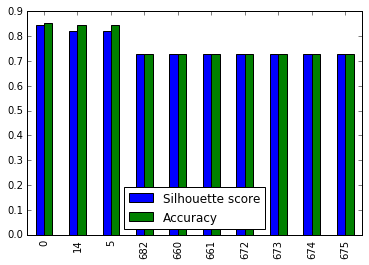

In [36]:
top_values.plot.bar() # visualize it

Surprising enough, only considering `seIAT` ends up being the most accurate clustering, both with regards to accuracy, as well as the silhouette score.
`seExp` is a good indicator as well, also leading to a solid clustering, especially when also taking `seIAT` into account.